In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns

#load dataset
orig_chara = pd.read_csv("input_data/characteristics.csv")
orig_song_info = pd.read_csv("input_data/song_info.csv") 

Data preprocessing

In [2]:
song_info = orig_song_info.copy()
chara = orig_chara.copy()
song_info.head(3)

,song_name,artist_name,album_names,playlist
0,Boulevard of Broken Dreams,Green Day,Greatest Hits: God's Favorite Band,00s Rock Anthems
1,In The End,Linkin Park,Hybrid Theory,00s Rock Anthems
2,Seven Nation Army,The White Stripes,Elephant,00s Rock Anthems


In [3]:
chara.isnull().sum()

song_name           0
song_popularity     0
song_duration_ms    0
acousticness        0
danceability        0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
audio_mode          0
speechiness         0
tempo               0
time_signature      0
audio_valence       0
dtype: int64

In [4]:
# The relationships between features
heatmap = chara.corr().style.background_gradient(cmap='coolwarm')

# Display the heatmap
heatmap

/var/folders/6k/kzw_ynb946l1476q2v62m3xc0000gn/T/ipykernel_13247/2773913247.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = chara.corr().style.background_gradient(cmap='coolwarm')


,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
song_popularity,1.000000,-0.018899,-0.065181,0.104290,0.001365,-0.130907,-0.013160,-0.038937,0.099442,-0.004969,0.021479,-0.022672,0.034983,-0.052895
song_duration_ms,-0.018899,1.000000,-0.097882,-0.104985,0.092688,-0.015188,-0.004615,0.016086,0.016469,-0.026328,-0.083447,0.012791,0.000264,-0.063421
acousticness,-0.065181,-0.097882,1.000000,-0.182500,-0.662639,0.173098,-0.002025,-0.082537,-0.557744,0.064100,-0.093574,-0.136421,-0.157177,-0.121670
danceability,0.104290,-0.104985,-0.182500,1.000000,0.044373,-0.130483,0.007723,-0.090694,0.177639,-0.106539,0.213728,-0.121286,0.136391,0.332014
energy,0.001365,0.092688,-0.662639,0.044373,1.000000,-0.205914,0.020416,0.167143,0.755516,-0.051605,0.062053,0.162448,0.146265,0.316742
instrumentalness,-0.130907,-0.015188,0.173098,-0.130483,-0.205914,1.000000,-0.009463,-0.032887,-0.390248,-0.014983,-0.081138,-0.036934,-0.069181,-0.178570
key,-0.013160,-0.004615,-0.002025,0.007723,0.020416,-0.009463,1.000000,-0.008193,0.010452,-0.169848,0.033639,0.003239,-0.008282,0.025356
liveness,-0.038937,0.016086,-0.082537,-0.090694,0.167143,-0.032887,-0.008193,1.000000,0.102450,-0.001035,0.090845,0.031876,0.013289,0.013789
loudness,0.099442,0.016469,-0.557744,0.177639,0.755516,-0.390248,0.010452,0.102450,1.000000,-0.058506,0.078164,0.129938,0.119241,0.199696
audio_mode,-0.004969,-0.026328,0.064100,-0.106539,-0.051605,-0.014983,-0.169848,-0.001035,-0.058506,1.000000,-0.111627,0.020448,-0.024042,-0.004558


<Axes: >

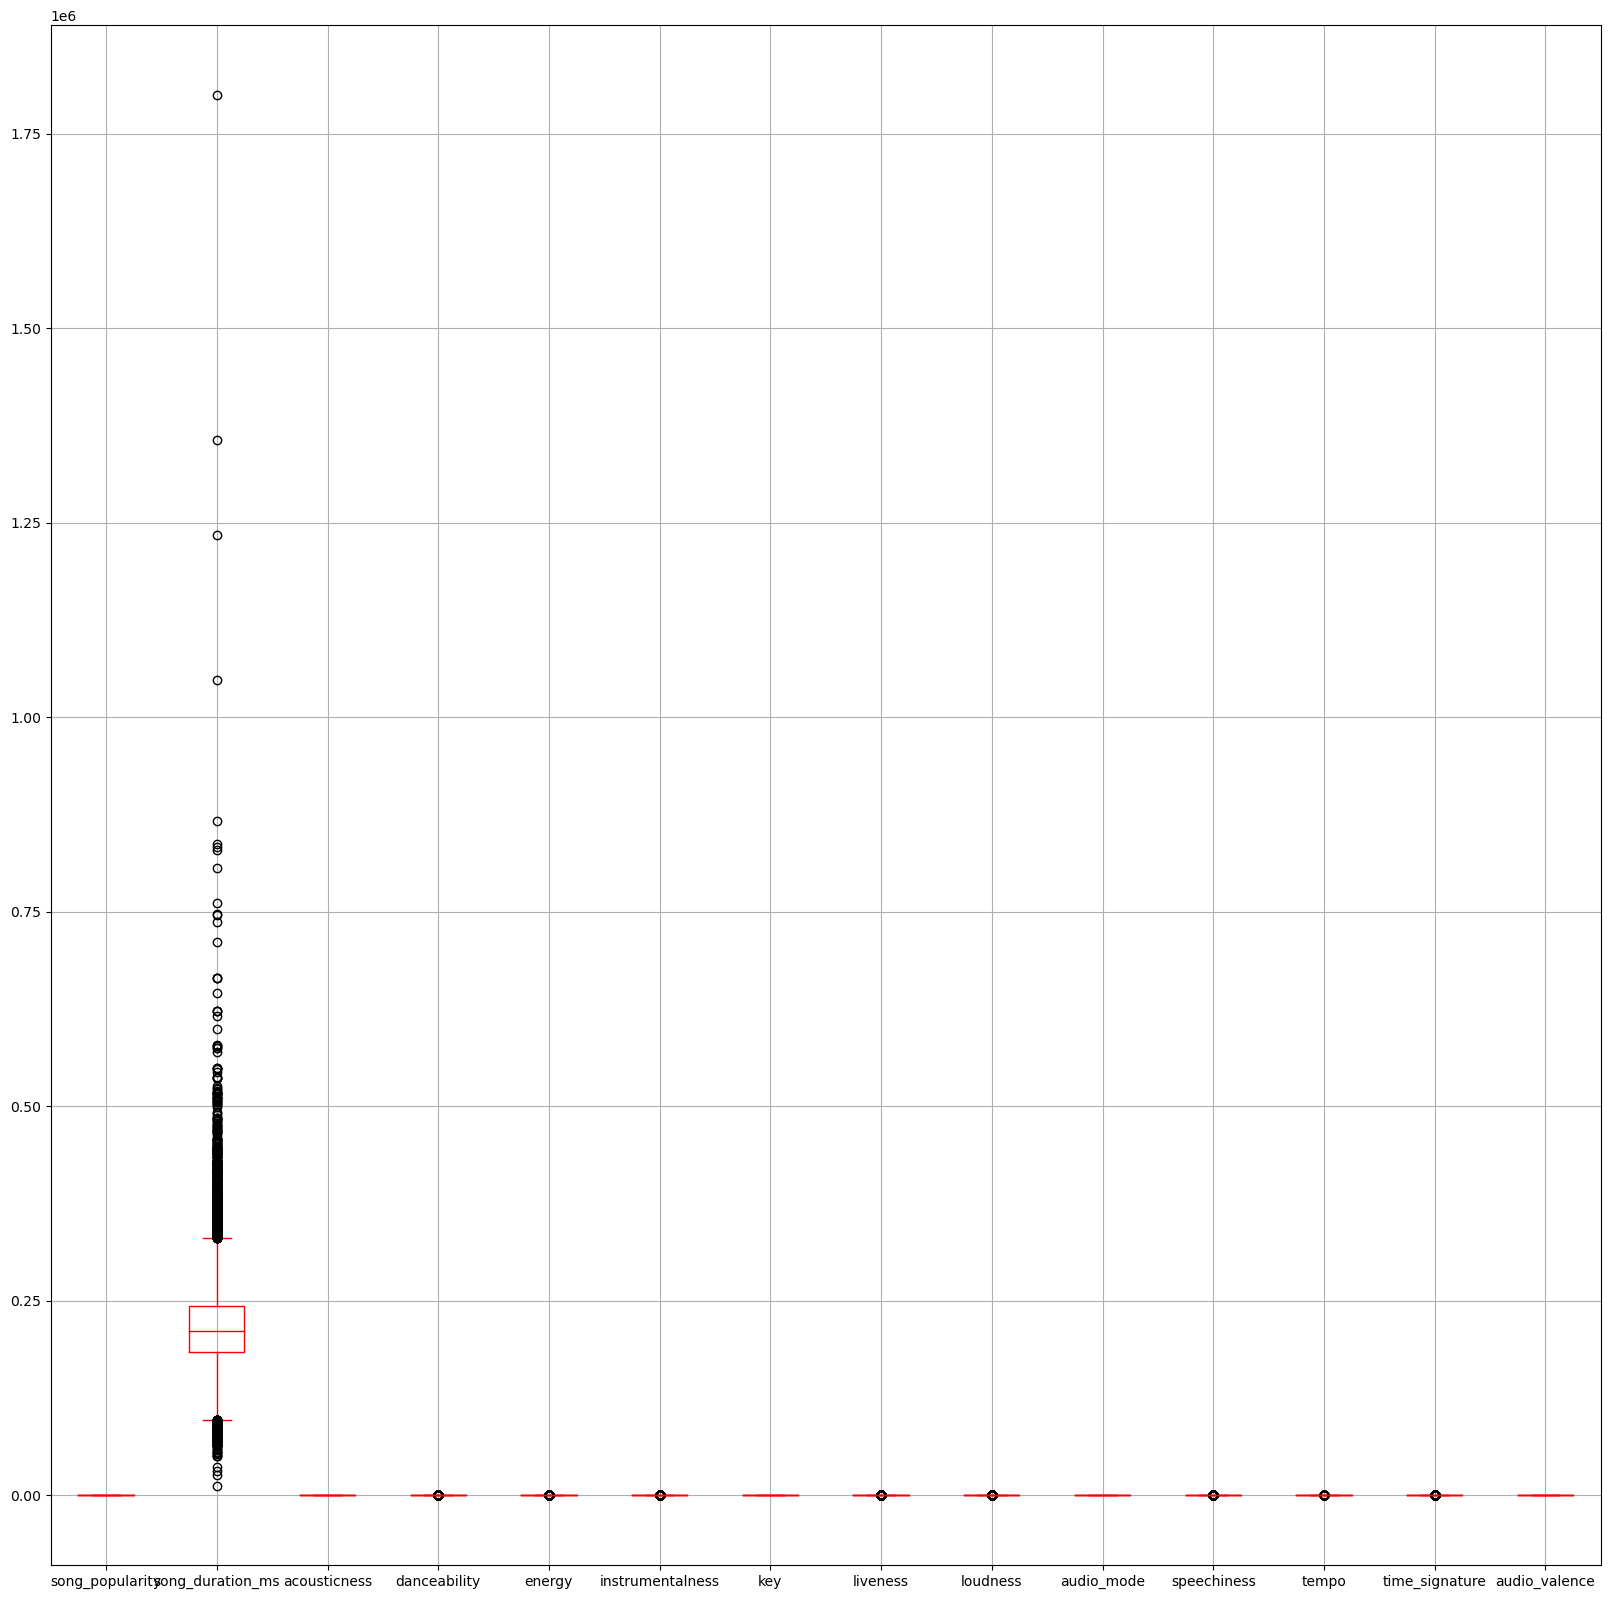

In [5]:
#outliers
chara.boxplot(figsize=(20, 20), color = 'red')

In [6]:
#detect outliers
from collections import Counter
def detect_outliers(df,features):
    outlier_indices = []
    
    for c in features:
        Q1 = np.percentile(df[c],25)
        Q3 = np.percentile(df[c],75)
        IQR = Q3 - Q1

        outlier_step = IQR * 1.5
        outlier_list_col = df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)].index #filtre
        outlier_indices.extend(outlier_list_col) 
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(i for i, v in outlier_indices.items() if v > 2) 
    
    return multiple_outliers
chara.loc[detect_outliers(chara,["song_popularity","song_duration_ms","danceability","energy","instrumentalness","liveness","loudness","speechiness","audio_valence"])]


,song_name,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
232,La Maza,58,351400,0.6520,0.555,0.331,0.000012,9,0.235,-17.718,0,0.2700,170.603,3,0.437
253,Whole Lotta Love,77,333893,0.0484,0.412,0.902,0.131000,9,0.405,-11.600,1,0.4050,89.740,4,0.422
501,Do You Feel Like We Do,48,836666,0.0439,0.295,0.568,0.011700,0,0.977,-8.232,1,0.0284,98.284,4,0.384
981,The Times They Are A-Changin' - Live at Sony M...,49,348560,0.6300,0.393,0.416,0.007910,9,0.986,-13.243,1,0.0401,163.604,3,0.512
1113,November Rain,38,537506,0.0165,0.197,0.629,0.279000,11,0.125,-9.291,1,0.0300,79.495,4,0.221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15247,I Know You So Well,8,102661,0.9230,0.679,0.311,0.721000,0,0.813,-16.557,0,0.1050,60.724,4,0.304
16642,same stars,46,116918,0.2510,0.687,0.284,0.862000,0,0.496,-19.504,1,0.0378,115.996,4,0.159
17723,Dutch Spring,0,205623,0.1960,0.510,0.843,0.135000,6,0.569,-4.958,0,0.3910,83.355,4,0.832
3720,Racism And Injustice,21,260160,0.9220,0.650,0.316,0.000000,9,0.739,-18.244,0,0.9400,117.198,4,0.306


In [7]:
# drop outliers
chara = chara.drop(detect_outliers(chara,["song_popularity","song_duration_ms","danceability","energy","instrumentalness","liveness","loudness","speechiness","audio_valence"]),axis = 0).reset_index(drop = True)

Feature Engineering

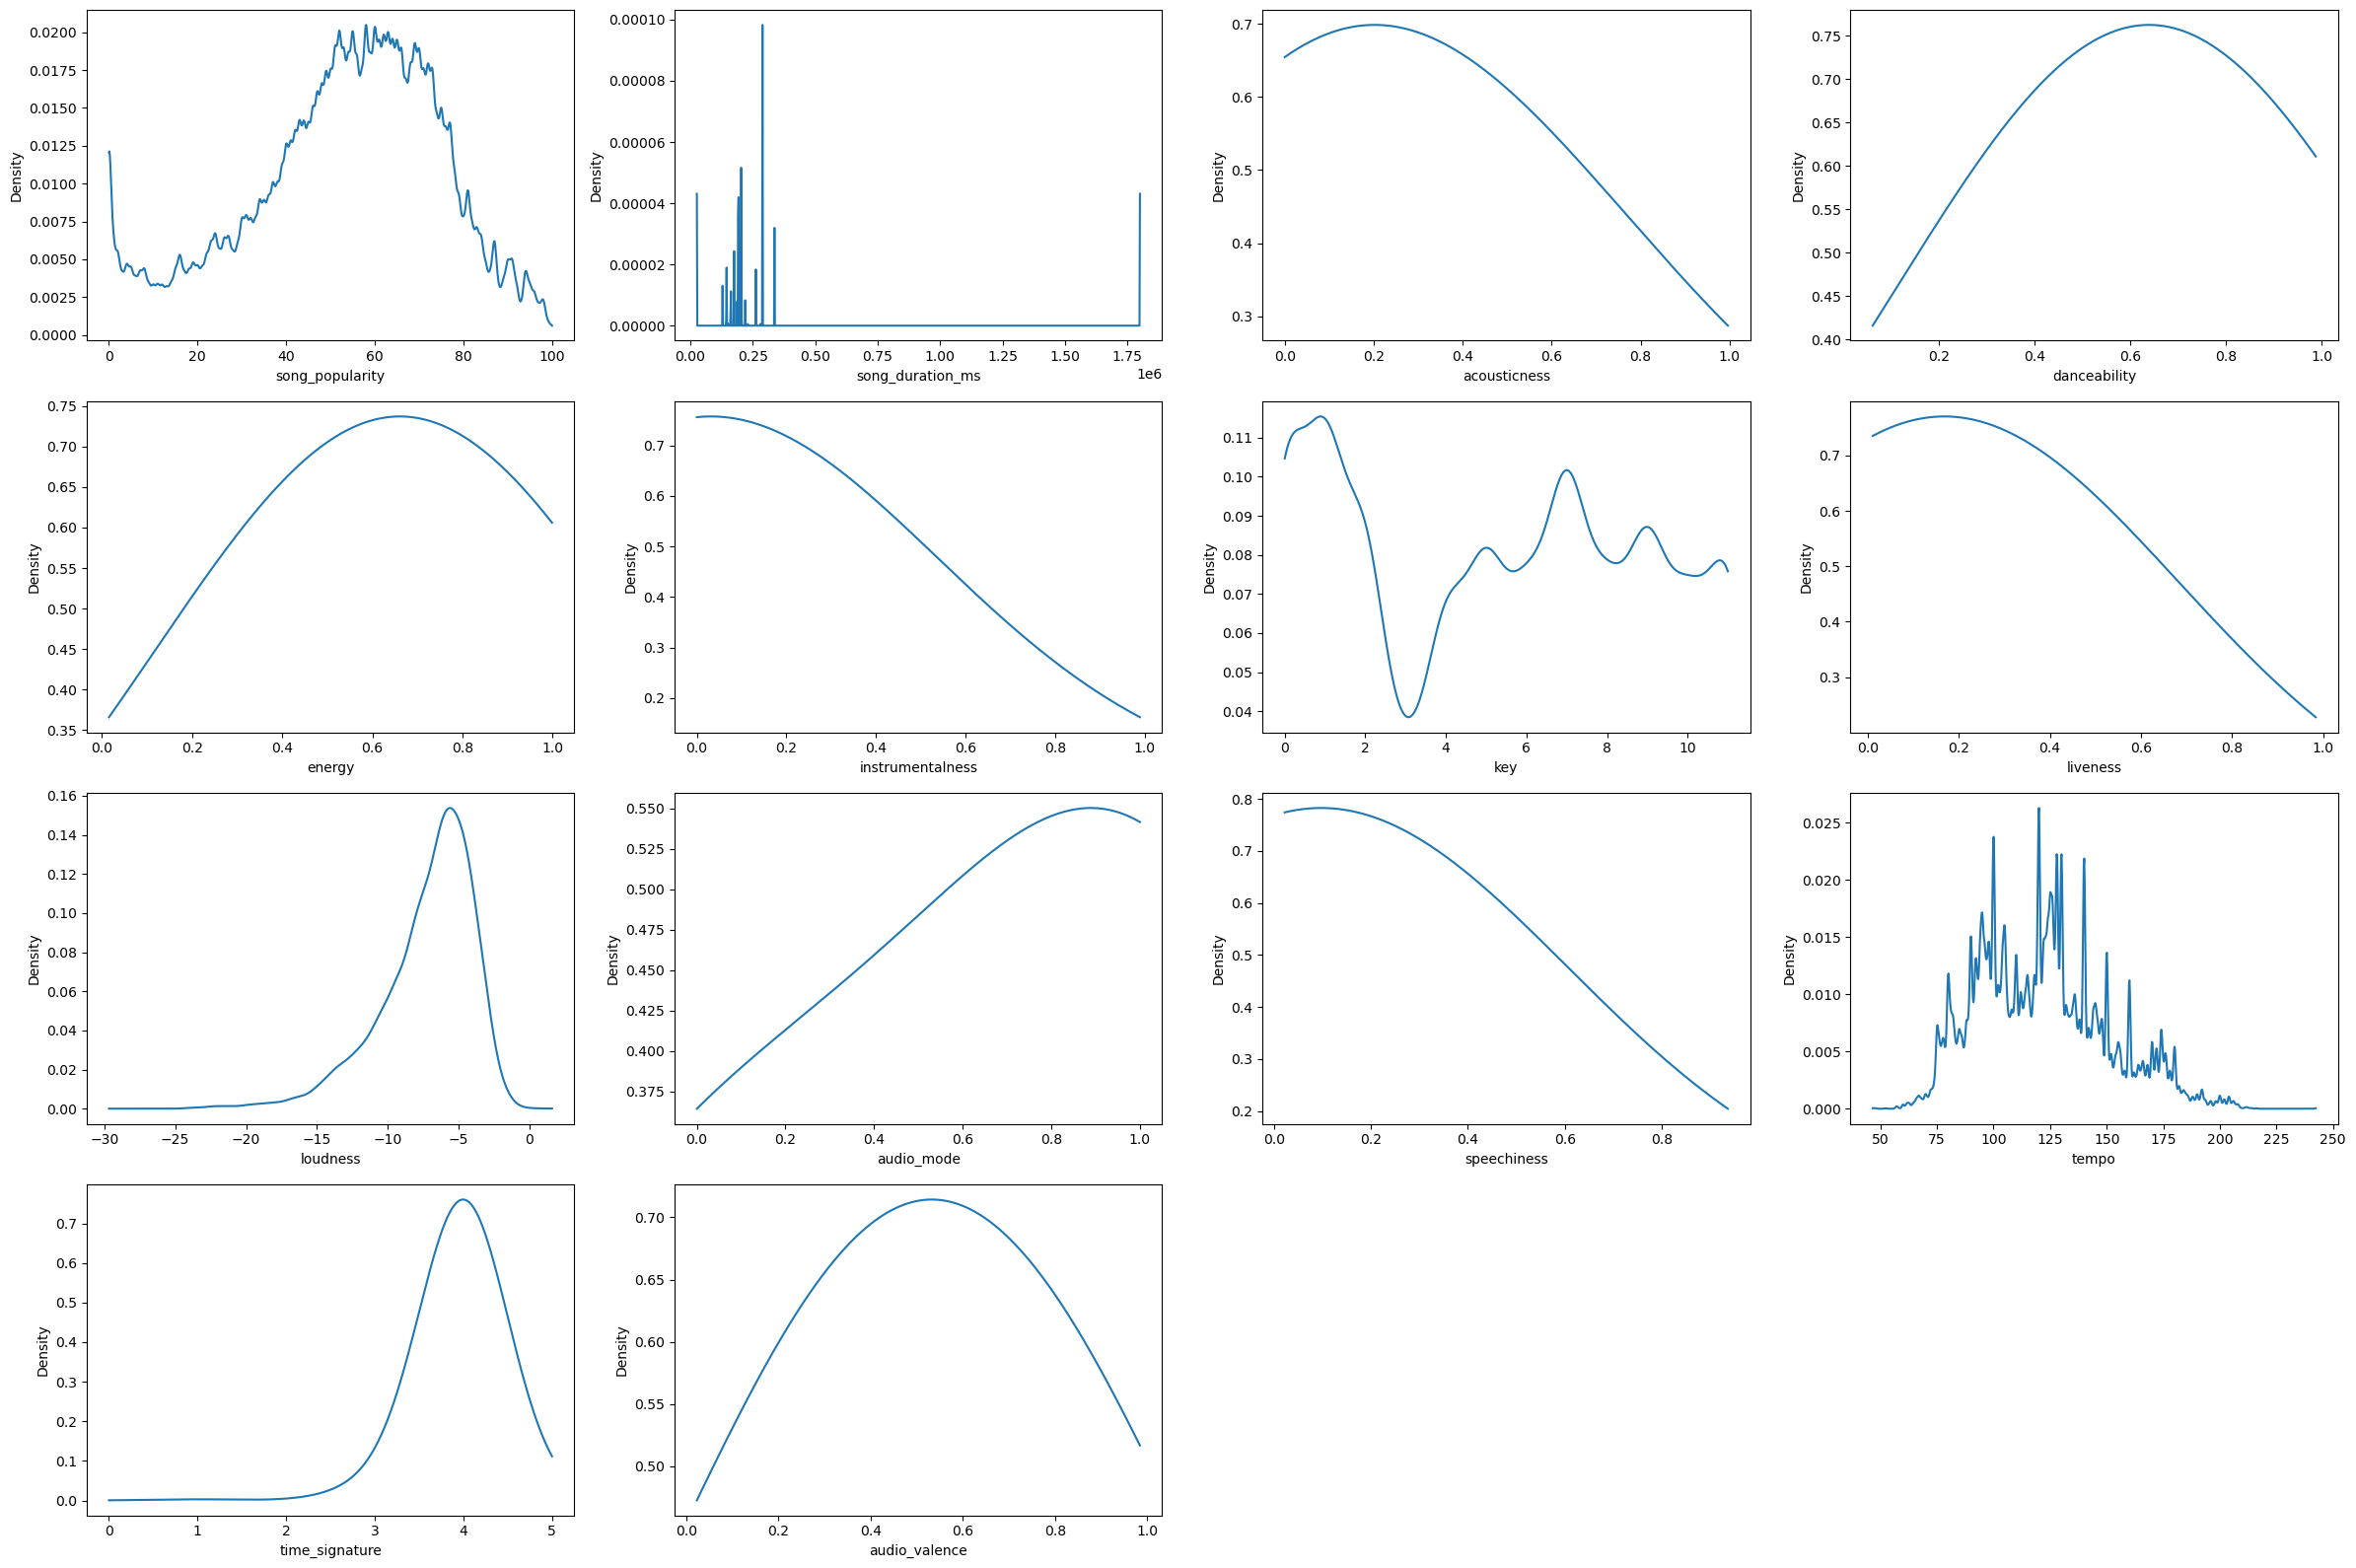

In [8]:
# make a kernel density estimate of the distribution for each feature
from sklearn.neighbors import KernelDensity
chara_no_name = chara.drop(["song_name"], axis=1)
nrows = (len(chara_no_name.columns) - 1) // 4 + 1
fig, axes = plt.subplots(nrows=nrows, ncols=4, figsize=(24, 4*nrows))

for i, col in enumerate(chara_no_name.columns):
    row_i = i // 4
    col_i = i % 4
    kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(chara_no_name[col].values.reshape(-1, 1))

    x_features = np.linspace(chara_no_name[col].min(), chara_no_name[col].max(), 1000)
    log_prob = kde.score_samples(x_features.reshape(-1, 1))

    axes[row_i, col_i].plot(x_features, np.exp(log_prob))
    # Set labels
    axes[row_i, col_i].set_xlabel(col)
    axes[row_i, col_i].set_ylabel('Density')

for i in range(len(chara_no_name.columns), nrows*4):
    row_i = i // 4
    col_i = i % 4
    fig.delaxes(axes[row_i, col_i])

plt.tight_layout()
plt.show()

In [9]:
chara.info()
chara.song_duration_ms= chara.song_duration_ms.astype(float)
chara.time_signature= chara.time_signature.astype(float)
chara.audio_mode= chara.audio_mode.astype(float)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18510 entries, 0 to 18509
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_name         18510 non-null  object 
 1   song_popularity   18510 non-null  int64  
 2   song_duration_ms  18510 non-null  int64  
 3   acousticness      18510 non-null  float64
 4   danceability      18510 non-null  float64
 5   energy            18510 non-null  float64
 6   instrumentalness  18510 non-null  float64
 7   key               18510 non-null  int64  
 8   liveness          18510 non-null  float64
 9   loudness          18510 non-null  float64
 10  audio_mode        18510 non-null  int64  
 11  speechiness       18510 non-null  float64
 12  tempo             18510 non-null  float64
 13  time_signature    18510 non-null  int64  
 14  audio_valence     18510 non-null  float64
dtypes: float64(9), int64(5), object(1)
memory usage: 2.1+ MB


In [10]:
#label popularity
chara["popularity"]= [ 1 if i>=66.5 else 0 for i in chara.song_popularity ]
chara["popularity"].value_counts()

0    13091
1     5419
Name: popularity, dtype: int64

In [11]:
data_polar = pd.concat([orig_chara.song_popularity,orig_chara.song_name],axis=1)
from textblob import TextBlob
data_polar['sentiment'] = data_polar['song_name'].map(lambda text: TextBlob(text).sentiment.polarity)
data_polar.head()

,song_popularity,song_name,sentiment
0,73,Boulevard of Broken Dreams,-0.4
1,66,In The End,0.0
2,76,Seven Nation Army,0.0
3,74,By The Way,0.0
4,56,How You Remind Me,0.0


In [12]:
import numpy as np
cut = pd.cut(
    data_polar['sentiment'],
    [-np.inf, -.01, .01, np.inf],
    labels=['negative', 'neutral', 'positive']
)
data_polar['polarity'] = cut.values
data_polar[['polarity','sentiment']].head()

,polarity,sentiment
0,negative,-0.4
1,neutral,0.0
2,neutral,0.0
3,neutral,0.0
4,neutral,0.0


In [13]:
chara = pd.concat([chara,data_polar.sentiment],axis=1)
chara.head()

,song_name,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,popularity,sentiment
0,Boulevard of Broken Dreams,73.0,262333.0,0.005520,0.496,0.682,0.000029,8.0,0.0589,-4.095,1.0,0.0294,167.060,4.0,0.474,1.0,-0.4
1,In The End,66.0,216933.0,0.010300,0.542,0.853,0.000000,3.0,0.1080,-6.407,0.0,0.0498,105.256,4.0,0.370,0.0,0.0
2,Seven Nation Army,76.0,231733.0,0.008170,0.737,0.463,0.447000,0.0,0.2550,-7.828,1.0,0.0792,123.881,4.0,0.324,1.0,0.0
3,By The Way,74.0,216933.0,0.026400,0.451,0.970,0.003550,0.0,0.1020,-4.938,1.0,0.1070,122.444,4.0,0.198,1.0,0.0
4,How You Remind Me,56.0,223826.0,0.000954,0.447,0.766,0.000000,10.0,0.1130,-5.065,1.0,0.0313,172.011,4.0,0.574,0.0,0.0


In [14]:
chara["audio_mode"] = chara["audio_mode"].astype("category")
chara = pd.get_dummies(chara, columns=["audio_mode"])
chara.head()

,song_name,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,time_signature,audio_valence,popularity,sentiment,audio_mode_0.0,audio_mode_1.0
0,Boulevard of Broken Dreams,73.0,262333.0,0.005520,0.496,0.682,0.000029,8.0,0.0589,-4.095,0.0294,167.060,4.0,0.474,1.0,-0.4,0,1
1,In The End,66.0,216933.0,0.010300,0.542,0.853,0.000000,3.0,0.1080,-6.407,0.0498,105.256,4.0,0.370,0.0,0.0,1,0
2,Seven Nation Army,76.0,231733.0,0.008170,0.737,0.463,0.447000,0.0,0.2550,-7.828,0.0792,123.881,4.0,0.324,1.0,0.0,0,1
3,By The Way,74.0,216933.0,0.026400,0.451,0.970,0.003550,0.0,0.1020,-4.938,0.1070,122.444,4.0,0.198,1.0,0.0,0,1
4,How You Remind Me,56.0,223826.0,0.000954,0.447,0.766,0.000000,10.0,0.1130,-5.065,0.0313,172.011,4.0,0.574,0.0,0.0,0,1


In [15]:
chara["key"] = chara["key"].astype("category")
chara = pd.get_dummies(chara, columns=["key"])
chara.head()

,song_name,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,...,key_2.0,key_3.0,key_4.0,key_5.0,key_6.0,key_7.0,key_8.0,key_9.0,key_10.0,key_11.0
0,Boulevard of Broken Dreams,73.0,262333.0,0.005520,0.496,0.682,0.000029,0.0589,-4.095,0.0294,...,0,0,0,0,0,0,1,0,0,0
1,In The End,66.0,216933.0,0.010300,0.542,0.853,0.000000,0.1080,-6.407,0.0498,...,0,1,0,0,0,0,0,0,0,0
2,Seven Nation Army,76.0,231733.0,0.008170,0.737,0.463,0.447000,0.2550,-7.828,0.0792,...,0,0,0,0,0,0,0,0,0,0
3,By The Way,74.0,216933.0,0.026400,0.451,0.970,0.003550,0.1020,-4.938,0.1070,...,0,0,0,0,0,0,0,0,0,0
4,How You Remind Me,56.0,223826.0,0.000954,0.447,0.766,0.000000,0.1130,-5.065,0.0313,...,0,0,0,0,0,0,0,0,1,0


In [16]:
chara["time_signature"] = chara["time_signature"].astype("category")
chara = pd.get_dummies(chara, columns=["time_signature"])
chara.head()

,song_name,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,...,key_7.0,key_8.0,key_9.0,key_10.0,key_11.0,time_signature_0.0,time_signature_1.0,time_signature_3.0,time_signature_4.0,time_signature_5.0
0,Boulevard of Broken Dreams,73.0,262333.0,0.005520,0.496,0.682,0.000029,0.0589,-4.095,0.0294,...,0,1,0,0,0,0,0,0,1,0
1,In The End,66.0,216933.0,0.010300,0.542,0.853,0.000000,0.1080,-6.407,0.0498,...,0,0,0,0,0,0,0,0,1,0
2,Seven Nation Army,76.0,231733.0,0.008170,0.737,0.463,0.447000,0.2550,-7.828,0.0792,...,0,0,0,0,0,0,0,0,1,0
3,By The Way,74.0,216933.0,0.026400,0.451,0.970,0.003550,0.1020,-4.938,0.1070,...,0,0,0,0,0,0,0,0,1,0
4,How You Remind Me,56.0,223826.0,0.000954,0.447,0.766,0.000000,0.1130,-5.065,0.0313,...,0,0,0,1,0,0,0,0,1,0


In [17]:
chara.drop(["song_popularity","song_name"],axis=1,inplace=True)

In [18]:
chara.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18835 entries, 0 to 18834
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   song_duration_ms    18510 non-null  float64
 1   acousticness        18510 non-null  float64
 2   danceability        18510 non-null  float64
 3   energy              18510 non-null  float64
 4   instrumentalness    18510 non-null  float64
 5   liveness            18510 non-null  float64
 6   loudness            18510 non-null  float64
 7   speechiness         18510 non-null  float64
 8   tempo               18510 non-null  float64
 9   audio_valence       18510 non-null  float64
 10  popularity          18510 non-null  float64
 11  sentiment           18835 non-null  float64
 12  audio_mode_0.0      18835 non-null  uint8  
 13  audio_mode_1.0      18835 non-null  uint8  
 14  key_0.0             18835 non-null  uint8  
 15  key_1.0             18835 non-null  uint8  
 16  key_

In [19]:
chara.isnull().sum()

song_duration_ms      325
acousticness          325
danceability          325
energy                325
instrumentalness      325
liveness              325
loudness              325
speechiness           325
tempo                 325
audio_valence         325
popularity            325
sentiment               0
audio_mode_0.0          0
audio_mode_1.0          0
key_0.0                 0
key_1.0                 0
key_2.0                 0
key_3.0                 0
key_4.0                 0
key_5.0                 0
key_6.0                 0
key_7.0                 0
key_8.0                 0
key_9.0                 0
key_10.0                0
key_11.0                0
time_signature_0.0      0
time_signature_1.0      0
time_signature_3.0      0
time_signature_4.0      0
time_signature_5.0      0
dtype: int64

In [20]:
chara = chara.dropna()

In [21]:
chara.isnull().sum()

song_duration_ms      0
acousticness          0
danceability          0
energy                0
instrumentalness      0
liveness              0
loudness              0
speechiness           0
tempo                 0
audio_valence         0
popularity            0
sentiment             0
audio_mode_0.0        0
audio_mode_1.0        0
key_0.0               0
key_1.0               0
key_2.0               0
key_3.0               0
key_4.0               0
key_5.0               0
key_6.0               0
key_7.0               0
key_8.0               0
key_9.0               0
key_10.0              0
key_11.0              0
time_signature_0.0    0
time_signature_1.0    0
time_signature_3.0    0
time_signature_4.0    0
time_signature_5.0    0
dtype: int64

In [22]:
chara.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18510 entries, 0 to 18509
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   song_duration_ms    18510 non-null  float64
 1   acousticness        18510 non-null  float64
 2   danceability        18510 non-null  float64
 3   energy              18510 non-null  float64
 4   instrumentalness    18510 non-null  float64
 5   liveness            18510 non-null  float64
 6   loudness            18510 non-null  float64
 7   speechiness         18510 non-null  float64
 8   tempo               18510 non-null  float64
 9   audio_valence       18510 non-null  float64
 10  popularity          18510 non-null  float64
 11  sentiment           18510 non-null  float64
 12  audio_mode_0.0      18510 non-null  uint8  
 13  audio_mode_1.0      18510 non-null  uint8  
 14  key_0.0             18510 non-null  uint8  
 15  key_1.0             18510 non-null  uint8  
 16  key_

In [23]:
X = chara.drop("popularity", axis=1)
y = chara["popularity"]

In [24]:
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)

In [25]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

LightGBM using Bayesian Optimization, Grid Search and Random Search

In [27]:
# lightGBM with bayesian optimization
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
import numpy as np
import time
from sklearn.model_selection import cross_val_score

start_time = time.time()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the search space for hyperparameters
search_space = {
    'learning_rate': (0.01, 1.0, 'log-uniform'),
    'max_depth': (2, 50),
    'num_leaves': (2, 50),
    'n_estimators': (10, 1000),
    'min_child_samples': (1, 50)
}
# Define the LGBMClassifier 
lgbm = lgb.LGBMClassifier(objective='binary', n_jobs=-1)

# Define the BayesSearchCV object with the objective function and search space
lgbm_bayes_search = BayesSearchCV(lgbm, search_space, scoring='accuracy', n_iter=20, cv=5)

# Fit the BayesSearchCV object to the training data
lgbm_bayes_search.fit(X_train, y_train)

# Print the best hyperparameters found by Bayesian optimization
best_params = lgbm_bayes_search.best_params_
print("Best hyperparameters: ", best_params)

lgbm_best_bayes = lgb.LGBMClassifier(**best_params)
lgbm_best_bayes.fit(X_train, y_train)


# Predict the test set labels using the best model found by Bayesian optimization
y_pred_lgbm_bayes = lgbm_best_bayes.predict(X_test)


end_time = time.time()

lgbm_bayes_time = end_time - start_time

# Calculate the evaluation metrics of the model on the test set
lgbm_bayes_accuracy = accuracy_score(y_test, y_pred_lgbm_bayes)
lgbm_bayes_prec = precision_score(y_test, y_pred_lgbm_bayes)
lgbm_bayes_rec = recall_score(y_test, y_pred_lgbm_bayes)
lgbm_bayes_f1 = f1_score(y_test, y_pred_lgbm_bayes)
lgbm_bayes_auc = roc_auc_score(y_test, y_pred_lgbm_bayes)


print("lgbm with BayesSearch:")
print("Accuracy: {:.4f}".format(lgbm_bayes_accuracy))
print("Precision: {:.4f}".format(lgbm_bayes_prec))
print("Recall: {:.4f}".format(lgbm_bayes_rec))
print("F1 score: {:.4f}".format(lgbm_bayes_f1))
print("ROC AUC score: {:.4f}".format(lgbm_bayes_auc))
print("Time: {:.2f} seconds".format(lgbm_bayes_time))

# Calculate the cross-validation scores for the model using the accuracy metric
scores = cross_val_score(lgbm_best_bayes, X, y, cv=5, scoring='accuracy')

# Print the mean and standard deviation of the cross-validation scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Best hyperparameters:  OrderedDict([('learning_rate', 0.05395409277534885), ('max_depth', 22), ('min_child_samples', 11), ('n_estimators', 1000), ('num_leaves', 49)])
lgbm with BayesSearch:
Accuracy: 0.8779
Precision: 0.8734
Recall: 0.6814
F1 score: 0.7656
ROC AUC score: 0.8203
Time: 111.20 seconds
Accuracy: 0.87 (+/- 0.05)


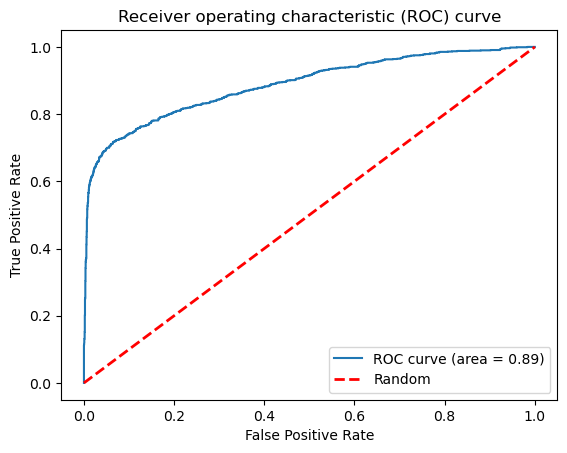

In [28]:
# ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class
y_prob = lgbm_best_bayes.predict_proba(X_test)[:, 1]

# Compute the false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

In [48]:
# lightGBM with grid search
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import time

start_time = time.time()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the search space for hyperparameters
search_space = {
    'learning_rate': [0.01, 0.1, 1.0],
    'max_depth': [2, 5, 10, 20, 50],
    'num_leaves': [2, 5, 10, 20, 50],
    'n_estimators': [10, 100, 500, 1000],
    'min_child_samples': [1, 10, 50]
}

# Define the LGBMClassifier 
lgbm = lgb.LGBMClassifier(objective='binary', n_jobs=-1)

# Define the GridSearchCV object with the objective function and search space
lgbm_grid_search = GridSearchCV(lgbm, search_space, scoring='accuracy', cv=5)

# Fit the BayesSearchCV object to the training data
lgbm_grid_search.fit(X_train, y_train)

# Print the best hyperparameters found by Bayesian optimization
best_params = lgbm_grid_search.best_params_
print("Best hyperparameters: ", best_params)

lgbm_best_grid = lgb.LGBMClassifier(**best_params)
lgbm_best_grid.fit(X_train, y_train)


# Predict the test set labels using the best model found by Bayesian optimization
y_pred_lgbm_grid = lgbm_best_grid.predict(X_test)


end_time = time.time()

lgbm_grid_time = end_time - start_time

# Calculate the evaluation metrics of the model on the test set
lgbm_grid_accuracy = accuracy_score(y_test, y_pred_lgbm_grid)
lgbm_grid_prec = precision_score(y_test, y_pred_lgbm_grid)
lgbm_grid_rec = recall_score(y_test, y_pred_lgbm_grid)
lgbm_grid_f1 = f1_score(y_test, y_pred_lgbm_grid)
lgbm_grid_auc = roc_auc_score(y_test, y_pred_lgbm_grid)


print("lgbm with GridSearch:")
print("Accuracy: {:.4f}".format(lgbm_grid_accuracy))
print("Precision: {:.4f}".format(lgbm_grid_prec))
print("Recall: {:.4f}".format(lgbm_grid_rec))
print("F1 score: {:.4f}".format(lgbm_grid_f1))
print("ROC AUC score: {:.4f}".format(lgbm_grid_auc))
print("Time: {:.2f} seconds".format(lgbm_grid_time))



Best hyperparameters:  {'learning_rate': 0.1, 'max_depth': 20, 'min_child_samples': 1, 'n_estimators': 1000, 'num_leaves': 50}
lgbm with GridSearch:
Accuracy: 0.8801
Precision: 0.8728
Recall: 0.6907
F1 score: 0.7711
ROC AUC score: 0.8245
Time: 1364.76 seconds


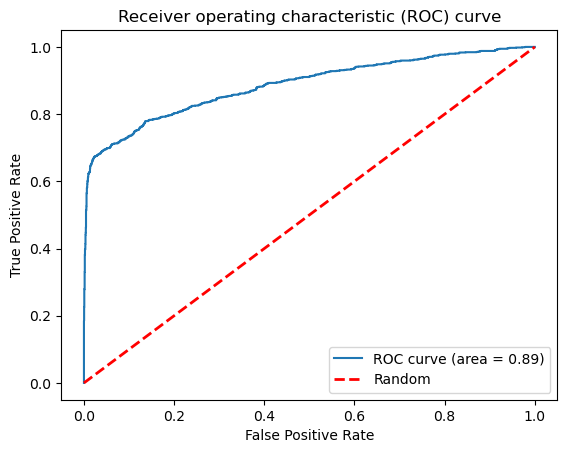

In [49]:
# ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class
y_prob = lgbm_best_grid.predict_proba(X_test)[:, 1]

# Compute the false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

In [29]:
# lightGBM with Randomized Search
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import numpy as np
import time
from sklearn.model_selection import cross_val_score

start_time = time.time()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the search space for hyperparameters
search_space = {
    'learning_rate': np.logspace(-3, 0, 100),
    'max_depth': np.arange(2, 50),
    'num_leaves': np.arange(2, 50),
    'n_estimators': np.arange(10, 1000),
    'min_child_samples': np.arange(1, 50)
}

# Define the LGBMClassifier 
lgbm = lgb.LGBMClassifier(objective='binary', n_jobs=-1)

# Define the RandomizedSearchCV object with the objective function and search space
lgbm_random_search = RandomizedSearchCV(lgbm, search_space, n_iter=20, cv=5, scoring='accuracy', random_state=42)

# Fit the RandomizedSearchCV object to the training data
lgbm_random_search.fit(X_train, y_train)

# Print the best hyperparameters found by Randomized Search
best_params = lgbm_random_search.best_params_
print("Best hyperparameters: ", best_params)

lgbm_best_random = lgb.LGBMClassifier(**best_params)
lgbm_best_random.fit(X_train, y_train)

# Predict the test set labels using the best model found by Randomized Search
y_pred_lgbm_random = lgbm_best_random.predict(X_test)

end_time = time.time()

lgbm_random_time = end_time - start_time

# Calculate the evaluation metrics of the model on the test set
lgbm_random_accuracy = accuracy_score(y_test, y_pred_lgbm_random)
lgbm_random_prec = precision_score(y_test, y_pred_lgbm_random)
lgbm_random_rec = recall_score(y_test, y_pred_lgbm_random)
lgbm_random_f1 = f1_score(y_test, y_pred_lgbm_random)
lgbm_random_auc = roc_auc_score(y_test, y_pred_lgbm_random)

print("lgbm_RandomizedSearch:")
print("Accuracy: {:.4f}".format(lgbm_random_accuracy))
print("Precision: {:.4f}".format(lgbm_random_prec))
print("Recall: {:.4f}".format(lgbm_random_rec))
print("F1 score: {:.4f}".format(lgbm_random_f1))
print("ROC AUC score: {:.4f}".format(lgbm_random_auc))
print("Time: {:.2f} seconds".format(lgbm_random_time))

# Calculate the cross-validation scores for the model using the accuracy metric
scores = cross_val_score(lgbm_best_random, X, y, cv=5, scoring='accuracy')

# Print the mean and standard deviation of the cross-validation scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))



Best hyperparameters:  {'num_leaves': 16, 'n_estimators': 975, 'min_child_samples': 31, 'max_depth': 12, 'learning_rate': 0.6135907273413176}
lgbm_RandomizedSearch:
Accuracy: 0.8609
Precision: 0.7940
Recall: 0.7082
F1 score: 0.7487
ROC AUC score: 0.8161
Time: 49.47 seconds
Accuracy: 0.85 (+/- 0.05)


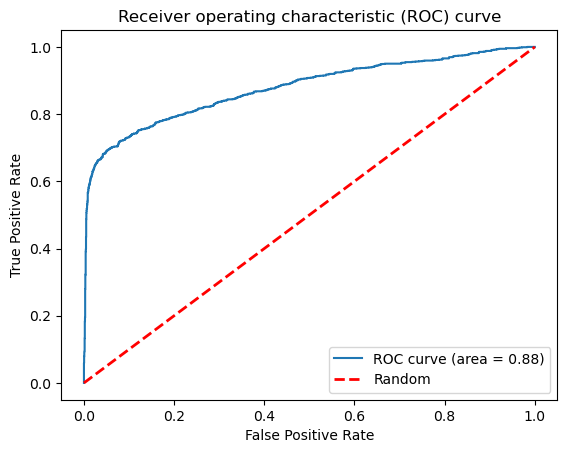

In [34]:
# ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class
y_prob = lgbm_best_random.predict_proba(X_test)[:, 1]

# Compute the false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

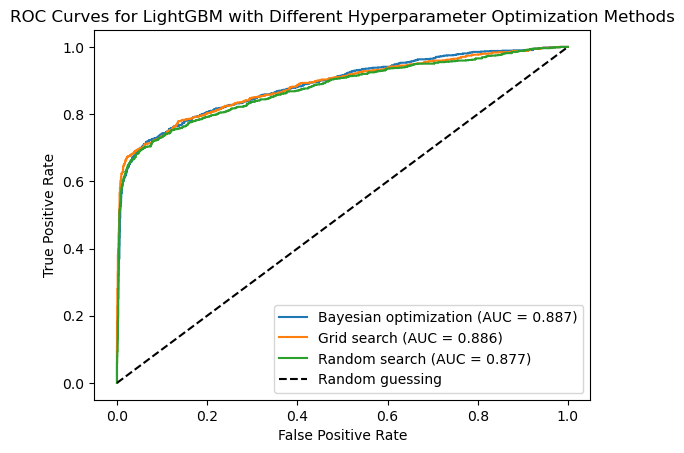

In [50]:
# Draw ROC curves on same plot
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Predict the probabilities for each model
bayes_y_prob = lgbm_best_bayes.predict_proba(X_test)[:, 1]
grid_y_prob = lgbm_best_grid.predict_proba(X_test)[:, 1]
random_y_prob = lgbm_best_random.predict_proba(X_test)[:, 1]

# Calculate the false positive rate and true positive rate for each model
bayes_fpr, bayes_tpr, _ = roc_curve(y_test, bayes_y_prob)
grid_fpr, grid_tpr, _ = roc_curve(y_test, grid_y_prob)
random_fpr, random_tpr, _ = roc_curve(y_test, random_y_prob)

# Calculate the AUC for each model
bayes_auc = auc(bayes_fpr, bayes_tpr)
grid_auc = auc(grid_fpr, grid_tpr)
random_auc = auc(random_fpr, random_tpr)

# Plot the ROC curves
plt.plot(bayes_fpr, bayes_tpr, label='Bayesian optimization (AUC = {:.3f})'.format(bayes_auc))
plt.plot(grid_fpr, grid_tpr, label='Grid search (AUC = {:.3f})'.format(grid_auc))
plt.plot(random_fpr, random_tpr, label='Random search (AUC = {:.3f})'.format(random_auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for LightGBM with Different Hyperparameter Optimization Methods')
plt.legend()
plt.show()

kNN using Bayesian Optimization, Grid Search and Random Search

In [46]:
# knn with Bayesian Optimization
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from skopt import BayesSearchCV
import time

start_time = time.time()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the search space for hyperparameters
search_space = {
    'n_neighbors': (1, 50),
    'p': (1, 5),
    'weights': ('uniform', 'distance'),
    'algorithm': ('auto', 'ball_tree', 'kd_tree')
}

# Define the KNN classifier
knn = KNeighborsClassifier()

# Define the BayesSearchCV object with the objective function and search space
knn_bayes_search = BayesSearchCV(knn, search_space, scoring='accuracy', n_iter=20, cv=5)

# Fit the BayesSearchCV object to the training data
knn_bayes_search.fit(X_train, y_train)

# Print the best hyperparameters found by Bayesian optimization
best_params = knn_bayes_search.best_params_
print("Best hyperparameters: ", best_params)

# Train the KNN classifier with the best hyperparameters found by Bayesian optimization
knn_best_bayes = KNeighborsClassifier(**best_params)
knn_best_bayes.fit(X_train, y_train)

# Predict the test set labels using the best model found by Bayesian optimization
y_pred_knn_bayes = knn_best_bayes.predict(X_test)

end_time = time.time()
knn_bayes_time = end_time - start_time

# Calculate the evaluation metrics of the model on the test set
knn_bayes_accuracy = accuracy_score(y_test, y_pred_knn_bayes)
knn_bayes_prec = precision_score(y_test, y_pred_knn_bayes)
knn_bayes_rec = recall_score(y_test, y_pred_knn_bayes)
knn_bayes_f1 = f1_score(y_test, y_pred_knn_bayes)
knn_bayes_auc = roc_auc_score(y_test, y_pred_knn_bayes)

# Print the evaluation metrics of the model on the test set
print("KNN with BayesSearch:")
print("Accuracy: {:.4f}".format(knn_bayes_accuracy))
print("Precision: {:.4f}".format(knn_bayes_prec))
print("Recall: {:.4f}".format(knn_bayes_rec))
print("F1 score: {:.4f}".format(knn_bayes_f1))
print("ROC AUC score: {:.4f}".format(knn_bayes_auc))
print("Time: {:.2f} seconds".format(knn_bayes_time  ))


/Users/zhangqiuyi/anaconda3/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/zhangqiuyi/anaconda3/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/zhangqiuyi/anaconda3/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Best hyperparameters:  OrderedDict([('algorithm', 'kd_tree'), ('n_neighbors', 50), ('p', 1), ('weights', 'distance')])
KNN with BayesSearch:
Accuracy: 0.8285
Precision: 0.7738
Recall: 0.5845
F1 score: 0.6660
ROC AUC score: 0.7569
Time: 575.75 seconds


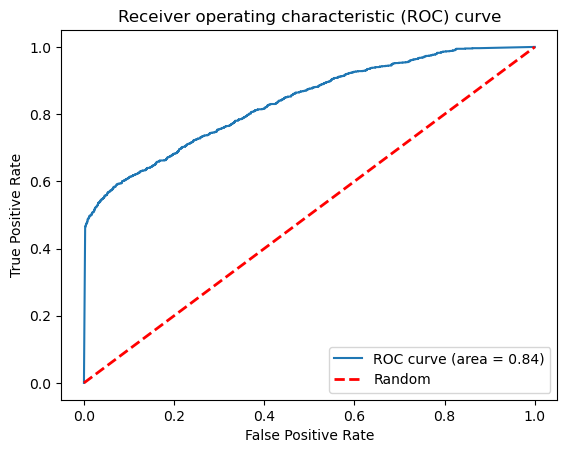

In [36]:
# ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class
y_prob = knn_best_bayes.predict_proba(X_test)[:, 1]

# Compute the false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

In [53]:
# knn with grid Search
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
import time

start_time = time.time()
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the search space for hyperparameters
search_space = {
    'n_neighbors': [i for i in range(0, 51, 10)],
    'p': [1, 2, 3],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree']
}

# Define the KNN classifier
knn = KNeighborsClassifier()

# Define the GridSearchCV object with the search space
knn_grid_search = GridSearchCV(knn, search_space, scoring='accuracy', cv=5)

# Fit the GridSearchCV object to the training data
knn_grid_search.fit(X_train, y_train)

# Print the best hyperparameters found by grid search
best_params = knn_grid_search.best_params_
print("Best hyperparameters: ", best_params)

# Train the KNN classifier with the best hyperparameters found by grid search
knn_best_grid = KNeighborsClassifier(**best_params)
knn_best_grid.fit(X_train, y_train)

# Predict the test set labels using the best model found by grid search
y_pred_knn_grid = knn_best_grid.predict(X_test)

end_time = time.time()

# Calculate the evaluation metrics of the model on the test set
knn_grid_accuracy = accuracy_score(y_test, y_pred_knn_grid)
knn_grid_prec = precision_score(y_test, y_pred_knn_grid)
knn_grid_rec = recall_score(y_test, y_pred_knn_grid)
knn_grid_f1 = f1_score(y_test, y_pred_knn_grid)
knn_grid_auc = roc_auc_score(y_test, y_pred_knn_grid)

# Print the evaluation metrics of the model on the test set
print("KNN with GridSearch:")
print("Accuracy: {:.4f}".format(knn_grid_accuracy))
print("Precision: {:.4f}".format(knn_grid_prec))
print("Recall: {:.4f}".format(knn_grid_rec))
print("F1 score: {:.4f}".format(knn_grid_f1))
print("ROC AUC score: {:.4f}".format(knn_grid_auc))
print("Time: {:.2f} seconds".format(end_time - start_time))



/Users/zhangqiuyi/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
90 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zhangqiuyi/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhangqiuyi/anaconda3/lib/python3.10/site-packages/sklearn/neighbors/_classification.py", line 213, in fit
    self._validate_params()
  File "/Users/zhangqiuyi/anaconda3/lib/python3.10/site-packages/sklearn/base.py", line 600, in _validate_params
    validate_parame

Best hyperparameters:  {'algorithm': 'ball_tree', 'n_neighbors': 50, 'p': 1, 'weights': 'distance'}
KNN with GridSearch:
Accuracy: 0.8285
Precision: 0.7738
Recall: 0.5845
F1 score: 0.6660
ROC AUC score: 0.7569
Time: 1952.92 seconds


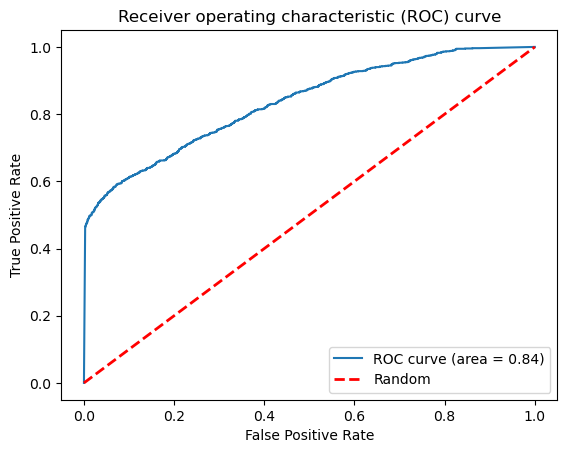

In [54]:
# ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class
y_prob = knn_best_grid.predict_proba(X_test)[:, 1]

# Compute the false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

In [51]:
# KNN with random search
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import time

start_time = time.time()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the search space for hyperparameters
search_space = {
    'n_neighbors': np.arange(0, 51, 10),
    'p': [1, 2, 3],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree']
}

# Define the KNN classifier
knn = KNeighborsClassifier()

# Define the RandomizedSearchCV object with the search space
knn_random_search = RandomizedSearchCV(knn, search_space, n_iter=20, scoring='accuracy', cv=5, random_state=42)

# Fit the RandomizedSearchCV object to the training data

knn_random_search.fit(X_train, y_train)

# Print the best hyperparameters found by random search
best_params = knn_random_search.best_params_
print("Best hyperparameters: ", best_params)

# Train the KNN classifier with the best hyperparameters found by random search
knn_best_random = KNeighborsClassifier(**best_params)
knn_best_random.fit(X_train, y_train)

# Predict the test set labels using the best model found by random search
y_pred_knn_random = knn_best_random.predict(X_test)

end_time = time.time()

# Calculate the evaluation metrics of the model on the test set
knn_random_accuracy = accuracy_score(y_test, y_pred_knn_random)
knn_random_prec = precision_score(y_test, y_pred_knn_random)
knn_random_rec = recall_score(y_test, y_pred_knn_random)
knn_random_f1 = f1_score(y_test, y_pred_knn_random)
knn_random_auc = roc_auc_score(y_test, y_pred_knn_random)

# Print the evaluation metrics of the model on the test set
print("KNN with RandomizedSearch:")
print("Accuracy: {:.4f}".format(knn_random_accuracy))
print("Precision: {:.4f}".format(knn_random_prec))
print("Recall: {:.4f}".format(knn_random_rec))
print("F1 score: {:.4f}".format(knn_random_f1))
print("ROC AUC score: {:.4f}".format(knn_random_auc))
print("Time: {:.2f} seconds".format(end_time - start_time))


/Users/zhangqiuyi/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/zhangqiuyi/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhangqiuyi/anaconda3/lib/python3.10/site-packages/sklearn/neighbors/_classification.py", line 213, in fit
    self._validate_params()
  File "/Users/zhangqiuyi/anaconda3/lib/python3.10/site-packages/sklearn/base.py", line 600, in _validate_params
    validate_parame

Best hyperparameters:  {'weights': 'distance', 'p': 1, 'n_neighbors': 50, 'algorithm': 'ball_tree'}
KNN with RandomizedSearch:
Accuracy: 0.8285
Precision: 0.7738
Recall: 0.5845
F1 score: 0.6660
ROC AUC score: 0.7569
Time: 299.78 seconds


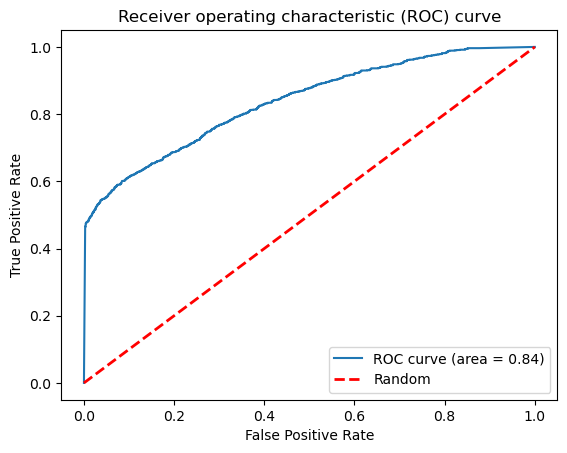

In [44]:
# ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class
y_prob = knn_best_random.predict_proba(X_test)[:, 1]

# Compute the false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

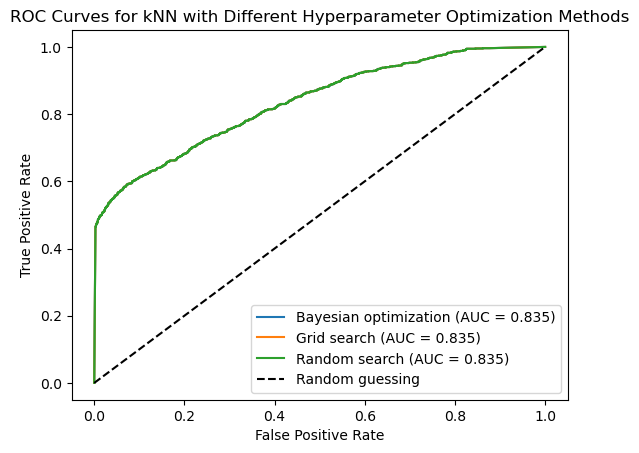

In [55]:
# Draw ROC on the same plot
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Predict the probabilities for each model
bayes_y_prob = knn_best_bayes.predict_proba(X_test)[:, 1]
grid_y_prob = knn_best_grid.predict_proba(X_test)[:, 1]
random_y_prob = knn_best_random.predict_proba(X_test)[:, 1]

# Calculate the false positive rate and true positive rate for each model
bayes_fpr, bayes_tpr, _ = roc_curve(y_test, bayes_y_prob)
grid_fpr, grid_tpr, _ = roc_curve(y_test, grid_y_prob)
random_fpr, random_tpr, _ = roc_curve(y_test, random_y_prob)

# Calculate the AUC for each model
bayes_auc = auc(bayes_fpr, bayes_tpr)
grid_auc = auc(grid_fpr, grid_tpr)
random_auc = auc(random_fpr, random_tpr)

# Plot the ROC curves
plt.plot(bayes_fpr, bayes_tpr, label='Bayesian optimization (AUC = {:.3f})'.format(bayes_auc))
plt.plot(grid_fpr, grid_tpr, label='Grid search (AUC = {:.3f})'.format(grid_auc))
plt.plot(random_fpr, random_tpr, label='Random search (AUC = {:.3f})'.format(random_auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for kNN with Different Hyperparameter Optimization Methods')
plt.legend()
plt.show()

SVM using Bayesian Optimization, Grid Search and Random Search

In [66]:
# SVM with bayesian optimization
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import time

start_time = time.time()

# Define the search space for hyperparameters
search_space = {
    'C': Real(0.01, 10.0, prior='log-uniform'),
    'gamma': Real(0.001, 1.0, prior='log-uniform')
}

# Define the SVM model
svm_rbf = SVR(kernel = 'rbf')

# Define the Bayesian optimization search with cross-validation
svm_bayes_search = BayesSearchCV(svm_rbf, search_space, n_iter=50, cv=5, n_jobs=-1)

# Fit the model to the training data
svm_bayes_search.fit(X_train, y_train)

# Get the best hyperparameters
bayes_best_params = svm_bayes_search.best_params_
print("Best hyperparameters(SVM Bayes): ", bayes_best_params)

# Train the model using the best hyperparameters
svm_best_bayes = SVR(kernel = 'rbf', C = bayes_best_params['C'], gamma = bayes_best_params['gamma'])
svm_best_bayes.fit(X_train, y_train)

# Evaluate the model on the testing data
y_pred_svm_bayes = svm_best_bayes.predict(X_test)
y_pred_svm_bayes = np.where(y_pred_svm_bayes > 0.665, 1, 0)

end_time = time.time()
svm_bayes_time = end_time - start_time

# Evaluate model performance
svm_bayes_accuracy = accuracy_score(y_test, y_pred_svm_bayes)
svm_bayes_prec = precision_score(y_test, y_pred_svm_bayes)
svm_bayes_rec = recall_score(y_test, y_pred_svm_bayes)
svm_bayes_f1 = f1_score(y_test, y_pred_svm_bayes)
svm_bayes_auc = roc_auc_score(y_test, y_pred_svm_bayes)


print("SVM(RBF)with Bayesian optimization:")
print("Accuracy: {:.4f}".format(svm_bayes_accuracy))
print("Precision: {:.4f}".format(svm_bayes_prec))
print("Recall: {:.4f}".format(svm_bayes_rec))
print("F1 score: {:.4f}".format(svm_bayes_f1))
print("ROC AUC score: {:.4f}".format(svm_bayes_auc))
print("Time: {:.2f} seconds".format(svm_bayes_time))

Best hyperparameters(SVM Bayes):  OrderedDict([('C', 0.5187755987396798), ('gamma', 1.0)])
SVM(RBF)with Bayesian optimization:
Accuracy: 0.8231
Precision: 0.9180
Recall: 0.4340
F1 score: 0.5893
ROC AUC score: 0.7090
Time: 2254.24 seconds


In [76]:
# SVM with grid search
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import time

start_time = time.time()

# Define the SVM model
svm_rbf = SVC(kernel='rbf')

# define the search space
search_space  = {
    'C': [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1, 2.5, 5, 7.5, 10],
    'gamma': [0.001, 0.005, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]
}

# Perform grid search to find the best hyperparameters
svm_grid_search = GridSearchCV(svm_rbf, search_space, cv = 5, n_jobs = -1)
svm_grid_search.fit(X_train, y_train)

# Get the best hyperparameters
svm_grid_best_params = svm_grid_search.best_params_
print("Best hyperparameters(SVM grid search): ", svm_grid_best_params)

# Train the model using the best hyperparameters
svm_best_grid = SVR(kernel = 'rbf', C = svm_grid_best_params['C'], gamma = svm_grid_best_params['gamma'])
svm_best_grid.fit(X_train, y_train)


# Evaluate the model on the testing data
y_pred_svm_grid = svm_best_grid.predict(X_test)
y_pred_svm_grid = np.where(y_pred_svm_grid > 0.665, 1, 0)

end_time = time.time()
svm_grid_time = end_time - start_time

# Evaluate model performance
svm_grid_accuracy = accuracy_score(y_test, y_pred_svm_grid)
svm_grid_prec = precision_score(y_test, y_pred_svm_grid)
svm_grid_rec = recall_score(y_test, y_pred_svm_grid)
svm_grid_f1 = f1_score(y_test, y_pred_svm_grid)
svm_grid_auc = roc_auc_score(y_test, y_pred_svm_grid)


print("SVM(RBF) with grid search:")
print("Accuracy: {:.4f}".format(svm_grid_accuracy))
print("Precision: {:.4f}".format(svm_grid_prec))
print("Recall: {:.4f}".format(svm_grid_rec))
print("F1 score: {:.4f}".format(svm_grid_f1))
print("ROC AUC score: {:.4f}".format(svm_grid_auc))
print("Time: {:.2f} seconds".format(svm_grid_time))

Best hyperparameters(SVM grid search):  {'C': 10, 'gamma': 1}
SVM(RBF) with grid search:
Accuracy: 0.8393
Precision: 0.9013
Recall: 0.5060
F1 score: 0.6481
ROC AUC score: 0.7415
Time: 2213.02 seconds


In [67]:
# SVM with random search
import pandas as pd
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV
import time

start_time = time.time()


# define the model
svm_rbf = SVR(kernel = 'rbf')

# define the search space
search_space  = {'C': sp_uniform(0.01, 10),
              'gamma': sp_uniform(0.001, 1)}

# perform random search
svm_random_search = RandomizedSearchCV(svm_rbf, search_space,
                                   n_iter = 10, cv = 5, n_jobs = -1)

# fit the model on the training data
svm_random_search.fit(X_train, y_train)

# Get the best hyperparameters
svm_random_best_params = svm_random_search.best_params_
print("Best hyperparameters(SVM Random search): ", svm_random_best_params)

# Train the model using the best hyperparameters
svm_best_random = SVR(kernel = 'rbf', C = svm_random_best_params['C'], gamma = svm_random_best_params['gamma'])
svm_best_random.fit(X_train, y_train)


# Evaluate the model on the testing data
y_pred_svm_random = svm_best_random.predict(X_test)
y_pred_svm_random = np.where(y_pred_svm_random > 0.665, 1, 0)

end_time = time.time()
svm_random_time = end_time - start_time

# Evaluate model performance
svm_random_accuracy = accuracy_score(y_test, y_pred_svm_random)
svm_random_prec = precision_score(y_test, y_pred_svm_random)
svm_random_rec = recall_score(y_test, y_pred_svm_random)
svm_random_f1 = f1_score(y_test, y_pred_svm_random)
svm_random_auc = roc_auc_score(y_test, y_pred_svm_random)


print("SVM(RBF) with random search:")
print("Accuracy: {:.4f}".format(svm_random_accuracy))
print("Precision: {:.4f}".format(svm_random_prec))
print("Recall: {:.4f}".format(svm_random_rec))
print("F1 score: {:.4f}".format(svm_random_f1))
print("ROC AUC score: {:.4f}".format(svm_random_auc))
print("Time: {:.2f} seconds".format(svm_random_time))

Best hyperparameters(SVM Random search):  {'C': 5.218984639834848, 'gamma': 0.872628225215564}
SVM(RBF) with random search:
Accuracy: 0.8387
Precision: 0.8882
Recall: 0.5134
F1 score: 0.6507
ROC AUC score: 0.7433
Time: 610.58 seconds


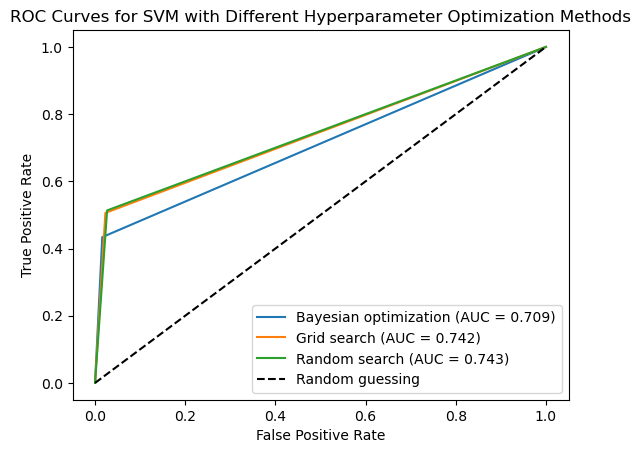

In [77]:
# Draw ROC curves on the same plot
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Predict the output for each model
bayes_y_pred = svm_best_bayes.predict(X_test)
grid_y_pred = svm_best_grid.predict(X_test)
random_y_pred = svm_best_random.predict(X_test)

# Choose a threshold value for binary classification
threshold = 0.665

# Convert the continuous predictions to binary predictions
bayes_y_prob = (bayes_y_pred > threshold).astype(int)
grid_y_prob = (grid_y_pred > threshold).astype(int)
random_y_prob = (random_y_pred > threshold).astype(int)

# Calculate the false positive rate and true positive rate for each model
bayes_fpr, bayes_tpr, _ = roc_curve(y_test, bayes_y_prob)
grid_fpr, grid_tpr, _ = roc_curve(y_test, grid_y_prob)
random_fpr, random_tpr, _ = roc_curve(y_test, random_y_prob)

# Calculate the AUC for each model
bayes_auc = auc(bayes_fpr, bayes_tpr)
grid_auc = auc(grid_fpr, grid_tpr)
random_auc = auc(random_fpr, random_tpr)

# Plot the ROC curves
plt.plot(bayes_fpr, bayes_tpr, label='Bayesian optimization (AUC = {:.3f})'.format(bayes_auc))
plt.plot(grid_fpr, grid_tpr, label='Grid search (AUC = {:.3f})'.format(grid_auc))
plt.plot(random_fpr, random_tpr, label='Random search (AUC = {:.3f})'.format(random_auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for SVM with Different Hyperparameter Optimization Methods')
plt.legend()
plt.show()

Random Forest using Bayesian Optimization, Grid Search and Random Search

In [71]:
# random forest with bayesian optimization
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import time

start_time = time.time()

# Define the search space
search_space = {
    'n_estimators': Integer(50, 300),
    'max_depth': Integer(10, 30),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 10),
    'max_features': Real(0.1, 1.0)
}

# Define the model
rf = RandomForestRegressor(random_state = 32)
# Define the search algorithm
rf_bayes_search = BayesSearchCV(rf,search_space,n_iter = 10,cv = 5,n_jobs = -1,scoring = 'neg_mean_squared_error')
# Fit the model to the data
rf_bayes_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params_rf_bayes = rf_bayes_search.best_params_
print("Best hyperparameters(Random Forest Bayes): ", best_params_rf_bayes)

# Define the model with the best hyperparameters
best_rf_bayes = RandomForestRegressor(random_state = 32, n_estimators = best_params_rf_bayes['n_estimators'], max_depth = best_params_rf_bayes['max_depth'], min_samples_split = best_params_rf_bayes['min_samples_split'], 
                                  min_samples_leaf = best_params_rf_bayes['min_samples_leaf'], max_features = best_params_rf_bayes['max_features'])

# Train the model on the training set
best_rf_bayes.fit(X_train, y_train)

# Evaluate the model on the testing data
y_pred_rf_bayes = best_rf_bayes.predict(X_test)
y_pred_rf_bayes = np.where(y_pred_rf_bayes > 0.665, 1, 0)

end_time = time.time()
rf_bayes_time = end_time - start_time

# Evaluate model performance
rf_bayes_accuracy = accuracy_score(y_test, y_pred_rf_bayes)
rf_bayes_prec = precision_score(y_test, y_pred_rf_bayes)
rf_bayes_rec = recall_score(y_test, y_pred_rf_bayes)
rf_bayes_f1 = f1_score(y_test, y_pred_rf_bayes)
rf_bayes_auc = roc_auc_score(y_test, y_pred_rf_bayes)

print("Random Forest with bayesian optimization:")
print("Accuracy: {:.4f}".format(rf_bayes_accuracy))
print("Precision: {:.4f}".format(rf_bayes_prec))
print("Recall: {:.4f}".format(rf_bayes_rec))
print("F1 score: {:.4f}".format(rf_bayes_f1))
print("ROC AUC score: {:.4f}".format(rf_bayes_auc))
print("Time: {:.2f} seconds".format(rf_bayes_time))

Best hyperparameters(Random Forest Bayes):  OrderedDict([('max_depth', 23), ('max_features', 0.506073130985518), ('min_samples_leaf', 3), ('min_samples_split', 5), ('n_estimators', 282)])
Random Forest with bayesian optimization:
Accuracy: 0.8214
Precision: 0.9689
Recall: 0.4026
F1 score: 0.5688
ROC AUC score: 0.6986
Time: 109.22 seconds


In [72]:
# random forest with grid search
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import time

start_time = time.time()

# define the search space
search_space = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10],
    'max_features': [0.1, 1.0]
}

# initialize the Random Forest regressor model
rf = RandomForestRegressor(random_state = 32)

# initialize the Grid Search cross-validator
rf_grid_search = GridSearchCV(rf, search_space, cv = 5, n_jobs = -1, scoring = 'neg_mean_squared_error')

# fit the Grid Search model to the training data
rf_grid_search.fit(X_train, y_train)

# get the best parameters and score
best_params_rf_grid = rf_grid_search.best_params_
print("Best hyperparameters(Random Forest Grid): ", best_params_rf_grid)

# initialize a new Random Forest regressor with the best hyperparameters
best_rf_grid = RandomForestRegressor(random_state = 32, **best_params_rf_grid)

# train the new model on the entire training set
best_rf_grid.fit(X_train, y_train)

# Evaluate the model on the testing data
y_pred_rf_grid = best_rf_grid.predict(X_test)
y_pred_rf_grid = np.where(y_pred_rf_grid > 0.665, 1, 0)

end_time = time.time()
rf_grid_time = end_time - start_time

# Evaluate model performance
rf_grid_accuracy = accuracy_score(y_test, y_pred_rf_grid)
rf_grid_prec = precision_score(y_test, y_pred_rf_grid)
rf_grid_rec = recall_score(y_test, y_pred_rf_grid)
rf_grid_f1 = f1_score(y_test, y_pred_rf_grid)
rf_grid_auc = roc_auc_score(y_test, y_pred_rf_grid)

print("Random Forest with Grid search:")
print("Accuracy: {:.4f}".format(rf_grid_accuracy))
print("Precision: {:.4f}".format(rf_grid_prec))
print("Recall: {:.4f}".format(rf_grid_rec))
print("F1 score: {:.4f}".format(rf_grid_f1))
print("ROC AUC score: {:.4f}".format(rf_grid_auc))
print("Time: {:.2f} seconds".format(rf_grid_time))

Best hyperparameters(Random Forest Grid):  {'max_depth': None, 'max_features': 0.1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest with Grid search:
Accuracy: 0.8684
Precision: 0.9715
Recall: 0.5669
F1 score: 0.7160
ROC AUC score: 0.7800
Time: 971.06 seconds


In [70]:
# random forest with random search
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import time

start_time = time.time()

# define the search space
search_space = {'n_estimators': randint(50, 100),
              'max_depth': randint(10, 30),
              'min_samples_split': randint(2, 10),
              'min_samples_leaf': randint(1, 10),
              'max_features': [0.1, 1.0]}

# create a random forest regressor
rf = RandomForestRegressor(random_state = 32)

# create a random search object
rf_random_search = RandomizedSearchCV(rf, search_space,n_iter = 10,cv = 5,n_jobs = -1,random_state = 32)

# fit the random search object to the data
rf_random_search.fit(X_train, y_train)

# get the best parameters and score
best_params_rf_random = rf_random_search.best_params_
print("Best hyperparameters(Random Forest Random search): ", best_params_rf_random)

# initialize a new Random Forest regressor with the best hyperparameters
best_rf_random = RandomForestRegressor(random_state = 32, **best_params_rf_random)

# train the new model on the entire training set
best_rf_random.fit(X_train, y_train)

# Evaluate the model on the testing data
y_pred_rf_random = best_rf_random.predict(X_test)
y_pred_rf_random = np.where(y_pred_rf_random > 0.665, 1, 0)

end_time = time.time()
rf_random_time = end_time - start_time

# Evaluate model performance
rf_random_accuracy = accuracy_score(y_test, y_pred_rf_random)
rf_random_prec = precision_score(y_test, y_pred_rf_random)
rf_random_rec = recall_score(y_test, y_pred_rf_random)
rf_random_f1 = f1_score(y_test, y_pred_rf_random)
rf_random_auc = roc_auc_score(y_test, y_pred_rf_random)

print("Random Forest with Random search:")
print("Accuracy: {:.4f}".format(rf_random_accuracy))
print("Precision: {:.4f}".format(rf_random_prec))
print("Recall: {:.4f}".format(rf_random_rec))
print("F1 score: {:.4f}".format(rf_random_f1))
print("ROC AUC score: {:.4f}".format(rf_random_auc))
print("Time: {:.2f} seconds".format(rf_random_time))

Best hyperparameters(Random Forest Random search):  {'max_depth': 20, 'max_features': 1.0, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 74}
Random Forest with Random search:
Accuracy: 0.8201
Precision: 0.9664
Recall: 0.3989
F1 score: 0.5647
ROC AUC score: 0.6966
Time: 61.73 seconds


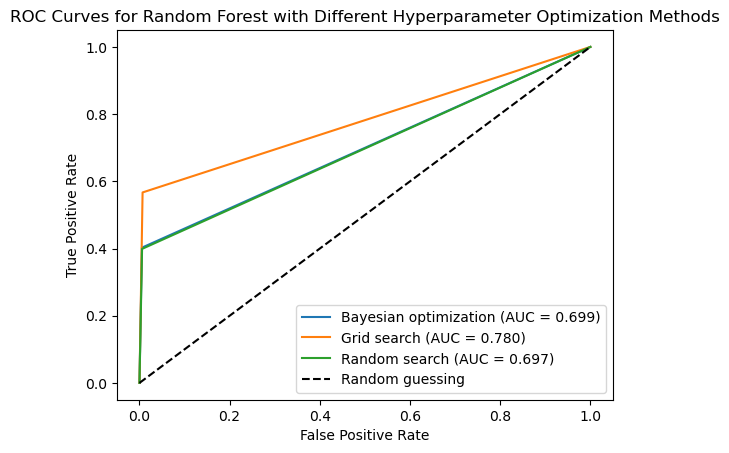

In [75]:
# Draw ROC curves on the same plot
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Predict the output for each model
bayes_y_pred = best_rf_bayes.predict(X_test)
grid_y_pred = best_rf_grid.predict(X_test)
random_y_pred = best_rf_random.predict(X_test)

# Choose a threshold value for binary classification
threshold = 0.665

# Convert the continuous predictions to binary predictions
bayes_y_prob = (bayes_y_pred > threshold).astype(int)
grid_y_prob = (grid_y_pred > threshold).astype(int)
random_y_prob = (random_y_pred > threshold).astype(int)

# Calculate the false positive rate and true positive rate for each model
bayes_fpr, bayes_tpr, _ = roc_curve(y_test, bayes_y_prob)
grid_fpr, grid_tpr, _ = roc_curve(y_test, grid_y_prob)
random_fpr, random_tpr, _ = roc_curve(y_test, random_y_prob)

# Calculate the AUC for each model
bayes_auc = auc(bayes_fpr, bayes_tpr)
grid_auc = auc(grid_fpr, grid_tpr)
random_auc = auc(random_fpr, random_tpr)

# Plot the ROC curves
plt.plot(bayes_fpr, bayes_tpr, label='Bayesian optimization (AUC = {:.3f})'.format(bayes_auc))
plt.plot(grid_fpr, grid_tpr, label='Grid search (AUC = {:.3f})'.format(grid_auc))
plt.plot(random_fpr, random_tpr, label='Random search (AUC = {:.3f})'.format(random_auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Random Forest with Different Hyperparameter Optimization Methods')
plt.legend()
plt.show()


Adaboost using Bayesian Optimization, Grid Search and Random Search

In [87]:
# AdaBoost with bayesian optimization
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import pandas as pd
import time

start_time = time.time()

# Define the base estimator for AdaBoost
ada_estimator= DecisionTreeRegressor(criterion='friedman_mse')

# Define the search space for BayesSearchCV
search_space = {
    'n_estimators': Integer(50, 100),
    'learning_rate': Real(0.1, 1)
}


# Create an AdaBoost model with BayesSearchCV
ada_bayes = AdaBoostRegressor(estimator=ada_estimator)
ada_bayes_search = BayesSearchCV(ada_bayes, search_space, n_iter = 20, scoring='neg_mean_squared_error', error_score='raise')
ada_bayes_search.fit(X_train, y_train)

# Get the best hyperparameters
ada_best_params_bayes = ada_bayes_search.best_params_
print("Best hyperparameters(AdaBoost Bayes): ", ada_best_params_bayes)

# Train the model using the best hyperparameters
best_ada_bayes = AdaBoostRegressor(estimator = ada_estimator, n_estimators = ada_best_params_bayes['n_estimators'], learning_rate = ada_best_params_bayes['learning_rate'])
best_ada_bayes.fit(X_train, y_train)

# Evaluate the model on the testing data
y_pred_ada_bayes = best_ada_bayes.predict(X_test)
y_pred_ada_bayes = np.where(y_pred_ada_bayes > 0.665, 1, 0)

end_time = time.time()
ada_bayes_time = end_time - start_time

# Evaluate model performance
ada_bayes_accuracy = accuracy_score(y_test, y_pred_ada_bayes)
ada_bayes_prec = precision_score(y_test, y_pred_ada_bayes)
ada_bayes_rec = recall_score(y_test, y_pred_ada_bayes)
ada_bayes_f1 = f1_score(y_test, y_pred_ada_bayes)
ada_bayes_auc = roc_auc_score(y_test, y_pred_ada_bayes)

print("AdaBoost with bayesian optimization:")
print("Accuracy: {:.4f}".format(ada_bayes_accuracy))
print("Precision: {:.4f}".format(ada_bayes_prec))
print("Recall: {:.4f}".format(ada_bayes_rec))
print("F1 score: {:.4f}".format(ada_bayes_f1))
print("ROC AUC score: {:.4f}".format(ada_bayes_auc))
print("Time: {:.2f} seconds".format(ada_bayes_time))

/Users/zhangqiuyi/anaconda3/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/zhangqiuyi/anaconda3/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/zhangqiuyi/anaconda3/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Best hyperparameters(AdaBoost Bayes):  OrderedDict([('learning_rate', 0.10335646211245691), ('n_estimators', 100)])
AdaBoost with bayesian optimization:
Accuracy: 0.8828
Precision: 0.9021
Recall: 0.6722
F1 score: 0.7704
ROC AUC score: 0.8210
Time: 1046.91 seconds


In [80]:
# Adaboost with gridSearch
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import time

start_time = time.time()

# Define the base estimator for AdaBoost
ada_estimator= DecisionTreeRegressor(criterion='friedman_mse')

# define the search space
search_space = {
    'n_estimators': [50, 75, 100],
    'learning_rate': [0.1, 0.5, 1]
}

# Create an AdaBoost model with GridSearchCV
ada_grid = AdaBoostRegressor(estimator = ada_estimator)
ada_grid_search = GridSearchCV(ada_grid, search_space, scoring = 'neg_mean_squared_error', error_score = 'raise')
ada_grid_search.fit(X_train, y_train)
# Get the best hyperparameters
best_params_grid = ada_grid_search.best_params_
print("Best hyperparameters(AdaBoost Grid): ", best_params_grid)

# Train the model using the best hyperparameters
best_ada_grid = AdaBoostRegressor(estimator = ada_estimator, n_estimators = best_params_grid['n_estimators'], learning_rate = best_params_grid['learning_rate'])
best_ada_grid.fit(X_train, y_train)

# Evaluate the model on the testing data
y_pred_ada_grid = best_ada_grid.predict(X_test)
y_pred_ada_grid = np.where(y_pred_ada_grid > 0.665, 1, 0)

end_time = time.time()
ada_grid_time = end_time - start_time

# Evaluate model performance
ada_grid_accuracy = accuracy_score(y_test, y_pred_ada_grid)
ada_grid_prec = precision_score(y_test, y_pred_ada_grid)
ada_grid_rec = recall_score(y_test, y_pred_ada_grid)
ada_grid_f1 = f1_score(y_test, y_pred_ada_grid)
ada_grid_auc = roc_auc_score(y_test, y_pred_ada_grid)

print("AdaBoost with grid search:")
print("Accuracy: {:.4f}".format(ada_grid_accuracy))
print("Precision: {:.4f}".format(ada_grid_prec))
print("Recall: {:.4f}".format(ada_grid_rec))
print("F1 score: {:.4f}".format(ada_grid_f1))
print("ROC AUC score: {:.4f}".format(ada_grid_auc))
print("Time: {:.2f} seconds".format(ada_grid_time))


Best hyperparameters(AdaBoost Grid):  {'learning_rate': 0.1, 'n_estimators': 100}
AdaBoost with grid search:
Accuracy: 0.8847
Precision: 0.9020
Recall: 0.6796
F1 score: 0.7751
ROC AUC score: 0.8245
Time: 1390.04 seconds


In [ ]:
# AdaBoost with random search
import numpy as np
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import time

start_time = time.time()

# Define the base estimator for AdaBoost
ada_estimator= DecisionTreeRegressor(criterion='friedman_mse')

# define the search space
search_space = {
    'n_estimators': [50,75, 100],
    'learning_rate':  [0.1, 0.5, 1]
}

# Initialize the model
ada_random = AdaBoostRegressor(estimator = DecisionTreeRegressor(criterion = 'friedman_mse'))

# Initialize RandomizedSearchCV
ada_random_search = RandomizedSearchCV(ada_random,
                                search_space,
                                n_iter = 10,
                                cv = 5,
                                n_jobs = -1)

# Fit the model
ada_random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params_random = ada_random_search.best_params_
print("Best hyperparameters(AdaBoost Random): ", best_params_random)

# Train the model using the best hyperparameters
best_ada_random = AdaBoostRegressor(estimator = DecisionTreeRegressor(criterion = 'friedman_mse'), n_estimators = best_params_random['n_estimators'], learning_rate = best_params_random['learning_rate'])
best_ada_random.fit(X_train, y_train)

# Evaluate the model on the testing data
y_pred_ada_random = best_ada_random.predict(X_test)
y_pred_ada_random = np.where(y_pred_ada_random > 0.665, 1, 0)

end_time = time.time()
ada_random_time = end_time - start_time

# Evaluate model performance
ada_random_accuracy = accuracy_score(y_test, y_pred_ada_random)
ada_random_prec = precision_score(y_test, y_pred_ada_random)
ada_random_rec = recall_score(y_test, y_pred_ada_random)
ada_random_f1 = f1_score(y_test, y_pred_ada_random)
ada_random_auc = roc_auc_score(y_test, y_pred_ada_random)


print("AdaBoost with random search:")
print("Accuracy: {:.4f}".format(ada_random_accuracy))
print("Precision: {:.4f}".format(ada_random_prec))
print("Recall: {:.4f}".format(ada_random_rec))
print("F1 score: {:.4f}".format(ada_random_f1))
print("ROC AUC score: {:.4f}".format(ada_random_auc))
print("Time: {:.2f} seconds".format(ada_random_time))

/Users/zhangqiuyi/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best hyperparameters(AdaBoost Random):  {'n_estimators': 75, 'learning_rate': 0.1}
AdaBoost with random search:
Accuracy: 0.8844
Precision: 0.9058
Recall: 0.6750
F1 score: 0.7735
ROC AUC score: 0.8230
Time: 121.62 seconds


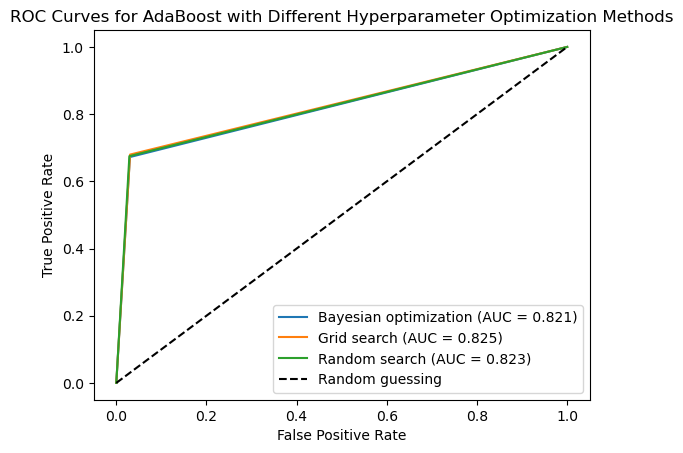

In [88]:
# Draw ROC curves on the same plot
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Predict the output for each model
bayes_y_pred = best_ada_bayes.predict(X_test)
grid_y_pred = best_ada_grid.predict(X_test)
random_y_pred = best_ada_random.predict(X_test)

# Choose a threshold value for binary classification
threshold = 0.665

# Convert the continuous predictions to binary predictions
bayes_y_prob = (bayes_y_pred > threshold).astype(int)
grid_y_prob = (grid_y_pred > threshold).astype(int)
random_y_prob = (random_y_pred > threshold).astype(int)

# Calculate the false positive rate and true positive rate for each model
bayes_fpr, bayes_tpr, _ = roc_curve(y_test, bayes_y_prob)
grid_fpr, grid_tpr, _ = roc_curve(y_test, grid_y_prob)
random_fpr, random_tpr, _ = roc_curve(y_test, random_y_prob)

# Calculate the AUC for each model
bayes_auc = auc(bayes_fpr, bayes_tpr)
grid_auc = auc(grid_fpr, grid_tpr)
random_auc = auc(random_fpr, random_tpr)

# Plot the ROC curves
plt.plot(bayes_fpr, bayes_tpr, label='Bayesian optimization (AUC = {:.3f})'.format(bayes_auc))
plt.plot(grid_fpr, grid_tpr, label='Grid search (AUC = {:.3f})'.format(grid_auc))
plt.plot(random_fpr, random_tpr, label='Random search (AUC = {:.3f})'.format(random_auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for AdaBoost with Different Hyperparameter Optimization Methods')
plt.legend()
plt.show()
